## Data preparation for encoding/decoding models

For this example, we will use the data from Haxby et al., 2001., which are shared via OpenNeuro:

https://openneuro.org/datasets/ds000105/versions/3.0.0

The data are formatted according to the BIDS standard: https://bids-specification.readthedocs.io/en/stable/index.html

First, import required dependencies. You can install these using `pip install -r requirements.txt` from the main repo directory.

In [1]:
%load_ext autoreload
%autoreload 2

import os
from nilearn import datasets, plotting
from nilearn.image import load_img, mean_img, resample_img
from nilearn.maskers import NiftiMasker
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map, plot_design_matrix
import h5py
import numpy as np
import nibabel as nib
import datalad.api as dl
from bids import BIDSLayout
from nilearn.glm.first_level import make_first_level_design_matrix
import pandas as pd
import matplotlib.pyplot as plt
from templateflow import api as tflow
import templateflow
from utils import (get_difumo_mask, 
                   get_subject_common_brain_mask,
                   get_group_common_mask,
                   get_subject_runs)

#### Get the data using datalad

We will use a tool called [Datalad](https://www.datalad.org/) to obtain the data from openneuro. 

We will download the raw data, as well as the processed data (using [fMRIPrep](https://fmriprep.org/en/stable/).  Note that downloading these derivative data can take quite a while depending on the speed of one's connection.  

In [2]:
data_dir = "/Users/poldrack/data_unsynced/ds000105"
assert os.path.exists(data_dir), "Data directory not found: %s" % data_dir

output_dir = os.path.join(data_dir, 'derivatives', 'glm')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
subdirs = ['zmaps', 'betas', 'subject_betas', 'group_zmaps']
for d in subdirs:
    if not os.path.exists(os.path.join(output_dir, d)):
        os.makedirs(os.path.join(output_dir, d))

# get the raw data
ds = dl.clone(
    path=data_dir,
    source="https://github.com/OpenNeuroDatasets/ds000105.git",
)
dl.get(dataset=data_dir, recursive=True)

get_fmriprep = False  #set to false after downloading fmriprep once
fmriprep_dir = os.path.join(data_dir, 'derivatives', 'fmriprep')

# get the preprocessed derivatives - this takes some time!
if get_fmriprep:
    dl.clone(
        path=fmriprep_dir,
        source='https://github.com/OpenNeuroDerivatives/ds000105-fmriprep.git')
    dl.get(dataset=fmriprep_dir, recursive=True)

[INFO] Ensuring presence of Dataset(/Users/poldrack/data_unsynced/ds000105) to get /Users/poldrack/data_unsynced/ds000105 


### Query the dataset using PyBIDS

Because the dataset is organized using the BIDS standard, we can use the [PyBIDS](https://bids-standard.github.io/pybids/) tool to query the dataset and obtain useful metadata.


In [3]:
# load the dataset using pybids and get runs for each subject

def get_layouts(data_dir, fmriprep_dir):
    
    layout = BIDSLayout(data_dir)
    deriv_layout = BIDSLayout(fmriprep_dir, derivatives=True, validate=False)
    return layout, deriv_layout

layout, deriv_layout = get_layouts(data_dir, fmriprep_dir)


/Users/poldrack/micromamba/envs/aineuro/lib/python3.12/site-packages/bids/layout/layout.py:516: UserWarning: Derivative indexing was requested, but no valid datasets were found in the specified locations ([PosixPath('/Users/poldrack/data_unsynced/ds000105/derivatives/fmriprep/derivatives')]). Note that all BIDS-Derivatives datasets must meet all the requirements for BIDS-Raw datasets (a common problem is to fail to include a 'dataset_description.json' file in derivatives datasets).
Example contents of 'dataset_description.json':
{"Name": "Example dataset", "BIDSVersion": "1.0.2", "GeneratedBy": [{"Name": "Example pipeline"}]}
  warnings.warn("Derivative indexing was requested, but no valid "


### Create common mask for each subject

Each run will have slightly different voxels included in its brain mask, but we want to have a common mask across all runs, so we will generate a mask that includes the intersection of masks across all of the individual subs/runs.

In [4]:
group_mask = get_group_common_mask(layout)

### Fit linear models for each subject/run

For each subject/run, we will load the preprocessed data and fit a model based on the task, along with confound regressors for head motion.  

In [5]:
def get_design_matrix(events, bold_img, deriv_layout, confounds=None,
                      drift_model='Cosine', high_pass=0.01, hrf_model='spm + derivative'):
    # define metadata for design matrix
    n_scans = bold_img.shape[-1]
    # Define the sampling times for the design matrix
    t_r = deriv_layout.get_metadata(bold_file[0])['RepetitionTime']
    frame_times = np.arange(n_scans) * t_r

    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model=drift_model,
        high_pass=high_pass,
        add_regs=confounds.values if confounds is not None else None,
    )
    return design_matrix, t_r


def get_events(subject, run, layout):
    # events file lives in the raw bold dir so we use the raw layout
    events_file = layout.get(subject=subject, run=run, datatype='func', 
                             suffix='events', extension='tsv', return_type='file')
    assert len(events_file) == 1, f"Found {len(events_file)} events files for {subject} {run}"
    events = pd.read_csv(events_file[0], sep='\t')
    return events


def get_bold_img(subject, run, deriv_layout):
    bold_file = deriv_layout.get(datatype='func', desc='preproc', suffix='bold',
                            space='MNI152NLin2009cAsym',
                            subject=subject, run=f'{run:02d}',
                            extension='nii.gz', return_type='file')
    assert len(bold_file) == 1
    bold_img = nib.load(bold_file[0])
    return bold_file, bold_img


def get_confounds(deriv_layout):
    confound_files = deriv_layout.get(datatype='func', desc='confounds', suffix='timeseries',
                                      subject=subject, run='01', extension='tsv', return_type='file')
    assert len(confound_files) == 1
    confounds = pd.read_csv(confound_files[0], sep='\t')
    confounds = confounds[[i for i in confounds.columns if 'rot' in i or 'trans' in i]]
    confounds = confounds.bfill()  # replace NaNs
    return confounds


# test the functions
subject = 1
run = 1
bold_file, bold_img = get_bold_img(subject, run, deriv_layout)
events = get_events(subject, run, layout)
confounds = get_confounds(deriv_layout)
desmtx, t_r = get_design_matrix(events, bold_img, deriv_layout, confounds=confounds)


### Visualize the design

We can look at the design matrix to see how it is modeling the different conditions

Text(0.5, 1.0, 'Design matrix for a single run')

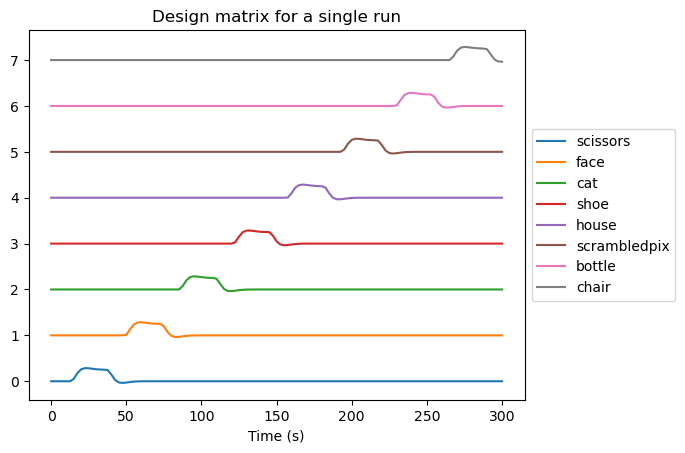

In [6]:
conditions = events.trial_type.unique()
n_scans = bold_img.shape[-1]
# Define the sampling times for the design matrix
t_r = deriv_layout.get_metadata(bold_file[0])['RepetitionTime']
frame_times = np.arange(n_scans) * t_r

for i, condition in enumerate(conditions):
    plt.plot(t_r * np.arange(0, desmtx.shape[0]), i + desmtx[condition])
plt.legend(conditions, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.title('Design matrix for a single run')

### Generate combined dataset

Here we run the analysis on each subject/session, extract the data from a mask including the visual cortices (based on the [Difumo Atlas](https://parietal-inria.github.io/DiFuMo/)) and save them to an HDF5 file for later reuse.

In [9]:
def get_subject_data(subject, run, layout, deriv_layout, 
                     save_maps=True, plot_slices=False,
                     hrf_model='spm + derivative',
                     use_confounds=True, smoothing_fwhm=3):
    """
    Get the data for a single subject and run

    Parameters
    ----------
    subject : str
        subject ID
    run : int
        run number
    layout : BIDSLayout
        layout object for the raw data
    deriv_layout : BIDSLayout
        layout object for the preprocessed data
    save_maps : bool
        whether to save the zmaps and beta maps to disk
    plot_slices : bool
        whether to plot the slices of the zmaps
    
    Returns
    -------
    data : numpy array
        2D array of voxel data
    conditions : list
        list of condition names
    """
    
    run = int(run)

    # load preprocessed BOLD data
    bold_file, bold_img = get_bold_img(subject, run, deriv_layout)

    # load brain mask
    mask_img = get_group_common_mask(layout)
    mask_data = mask_img.get_fdata().astype(bool)

    events = get_events(subject, run, layout)

    if use_confounds:
        confounds = get_confounds(deriv_layout)
    else:
        confounds = None

    design_matrix, t_r = get_design_matrix(events, bold_img, deriv_layout, 
                                      confounds=confounds)
    
    # specify and fit the GLM to the bold data
    fmri_glm = FirstLevelModel(t_r, noise_model='ar1', standardize=False, 
                               hrf_model=hrf_model, smoothing_fwhm=smoothing_fwhm)
    fmri_glm = fmri_glm.fit(bold_img, design_matrices=design_matrix)

    # compute contrasts
    conditions = events.trial_type.unique()
    conditions.sort()
    z_map = {}
    smoothing_string = f"_fwhm-{smoothing_fwhm}" if smoothing_fwhm is not None else ""
    for condition in conditions:
        contrast = fmri_glm.compute_contrast(condition, output_type='all')
        z_map[condition] = contrast['z_score']
        if save_maps:
            contrast['z_score'].to_filename(os.path.join(output_dir,'zmaps', f'sub-{subject}_run-{run}_zmap_{condition}.nii.gz'))
            contrast['effect_size'].to_filename(os.path.join(output_dir, 'betas', f'sub-{subject}_run-{run}_beta_{condition}.nii.gz'))

    z_maps = nib.concat_images([z_map[condition] for condition in conditions])
    
    difumo_mask = get_difumo_mask()
    difumo_mask = resample_img(difumo_mask, target_affine=z_maps.affine, 
                               target_shape=z_maps.shape[:3],
                               interpolation='nearest')
    difumo_data = difumo_mask.get_fdata().astype(bool)
    # combine with common mask
    difumo_data = np.logical_and(difumo_data, mask_data)
    difumo_mask = nib.Nifti1Image(difumo_data.astype('int32'), difumo_mask.affine)
    masker = NiftiMasker(mask_img=difumo_mask, standardize=True, target_affine=z_maps.affine)
    data = masker.fit_transform(z_maps)
    assert data.shape == (len(conditions), difumo_mask.get_fdata().sum())
    return data, conditions


with h5py.File(os.path.join(output_dir, 'visctx_data.h5'), 'w') as hf:
    for subject in layout.get_subjects():
        sub_runs = get_subject_runs(subject, layout.root)
        g1 = hf.create_group(f'sub-{subject}')
        for run in sub_runs:
            g2 = g1.create_group(f'run-{run}')
            print(f"Processing subject {subject} run {run}")
            data, conditions = get_subject_data(subject, run, layout, deriv_layout)
            g2.create_dataset(f'voxdata',data=data)
            g2.create_dataset(f'conditions', data=[c.encode('utf-8') for c in conditions])

Processing subject 1 run 01
Processing subject 1 run 02
Processing subject 1 run 03
Processing subject 1 run 04
Processing subject 1 run 05
Processing subject 1 run 06
Processing subject 1 run 07
Processing subject 1 run 08
Processing subject 1 run 09
Processing subject 1 run 10
Processing subject 1 run 11
Processing subject 1 run 12
Processing subject 2 run 01
Processing subject 2 run 02
Processing subject 2 run 03
Processing subject 2 run 04
Processing subject 2 run 05
Processing subject 2 run 06
Processing subject 2 run 07
Processing subject 2 run 08
Processing subject 2 run 09
Processing subject 2 run 10
Processing subject 2 run 11
Processing subject 2 run 12
Processing subject 3 run 01
Processing subject 3 run 02
Processing subject 3 run 03
Processing subject 3 run 04
Processing subject 3 run 05
Processing subject 3 run 06
Processing subject 3 run 07
Processing subject 3 run 08
Processing subject 3 run 09
Processing subject 3 run 10
Processing subject 3 run 11
Processing subject 3

### Generate group statistical maps

As a reality check it is useful to compute a group statistical map for each of the conditions.  We first need to combine the data across runs within each subject, and then we do a group analysis.  This is a very underpowered analysis given the number of subjects, but it's useful for checking the modeling results.

In [10]:
# combine across runs within each subject

for subject in layout.get_subjects():
    for condition in conditions:
        subject_runs = get_subject_runs(subject, layout.root)
        beta_files = [os.path.join(output_dir, 'betas', f'sub-{subject}_run-{int(run)}_beta_{condition}.nii.gz') for run in subject_runs]
        model = SecondLevelModel()
        model.fit(beta_files, design_matrix=pd.DataFrame([1] * len(beta_files), columns=['intercept']))
        beta = model.compute_contrast(output_type='effect_size')
        beta.to_filename(os.path.join(output_dir, 'subject_betas', f'sub-{subject}_FEbeta_{condition}.nii.gz'))

In [11]:
# run group model

for condition in conditions:
    beta_files = [os.path.join(output_dir, 'subject_betas', f'sub-{subject}_FEbeta_{condition}.nii.gz') for subject in layout.get_subjects()]
    model = SecondLevelModel()
    model.fit(beta_files, design_matrix=pd.DataFrame([1] * len(beta_files), columns=['intercept']))
    z_map = model.compute_contrast(output_type='z_score')
    z_map.to_filename(os.path.join(output_dir, 'group_zmaps', f'group_zmap_{condition}.nii.gz'))


Display the maps for a quick reality check.

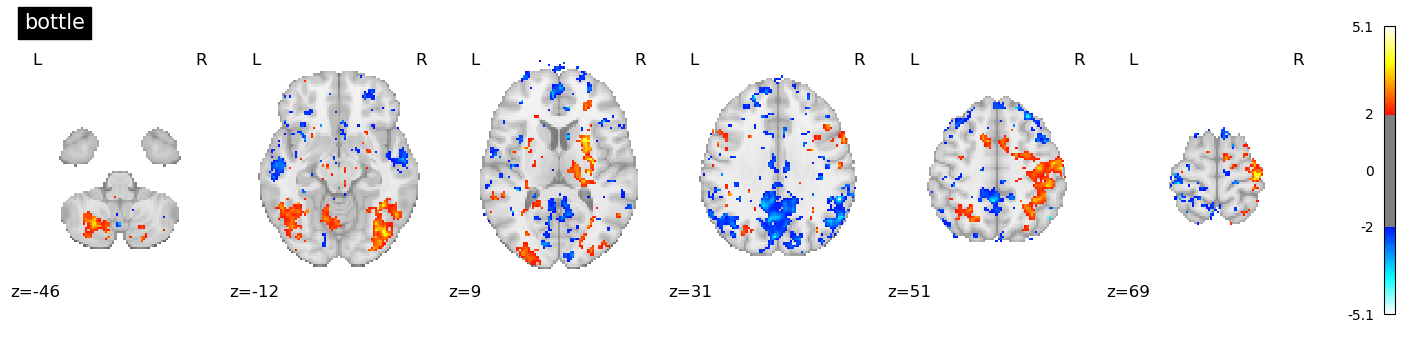

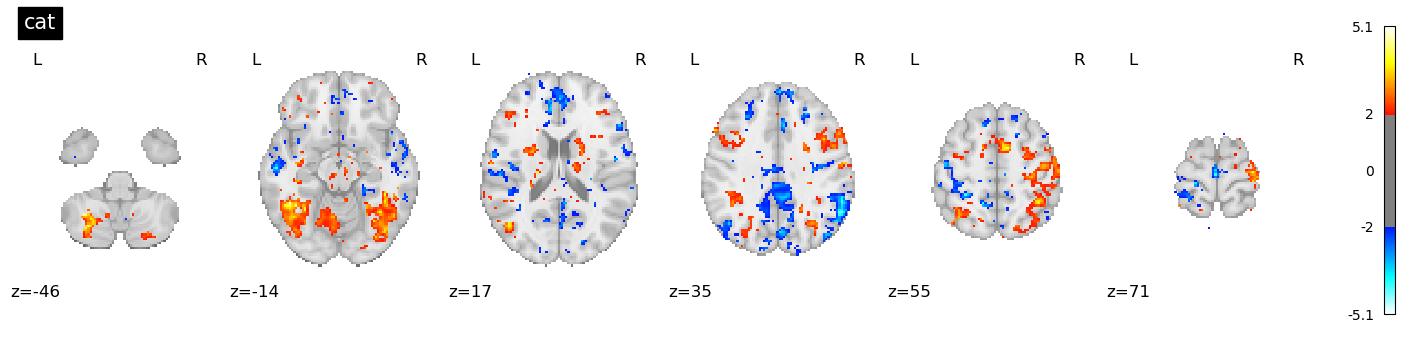

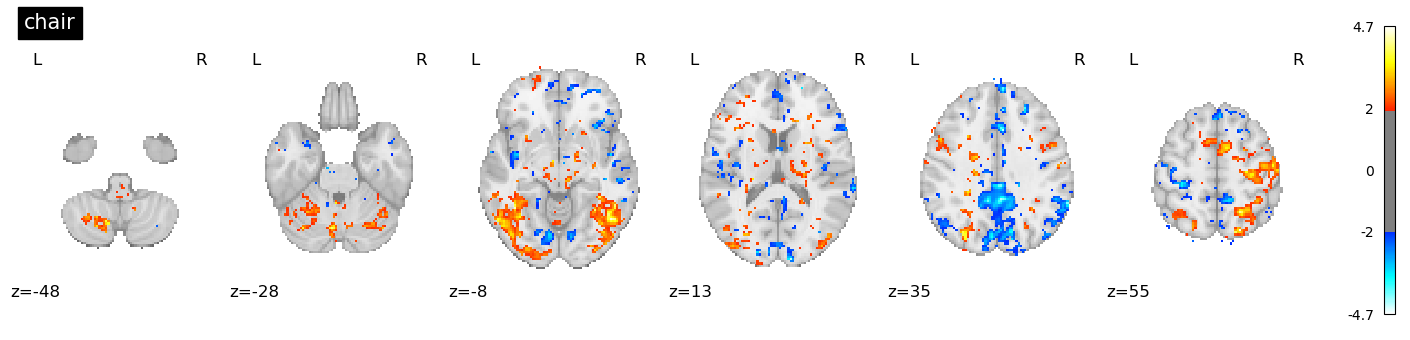

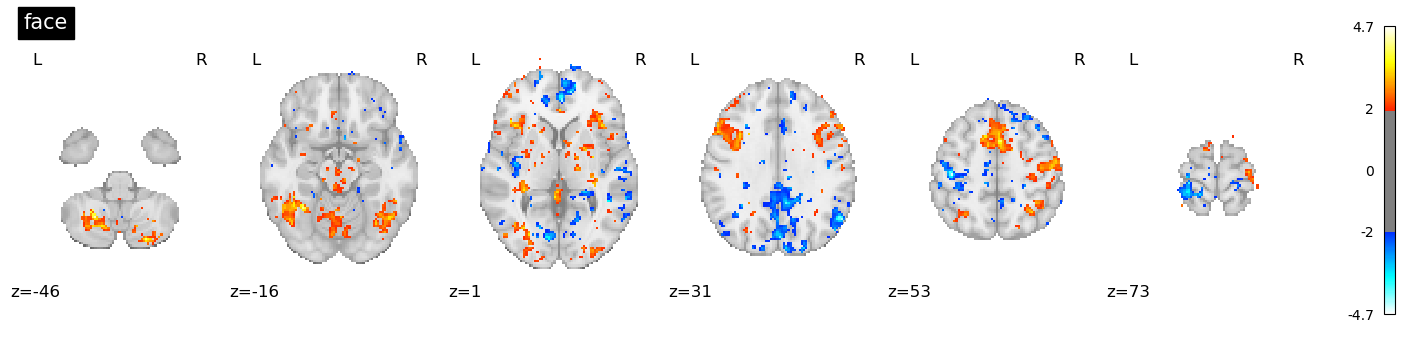

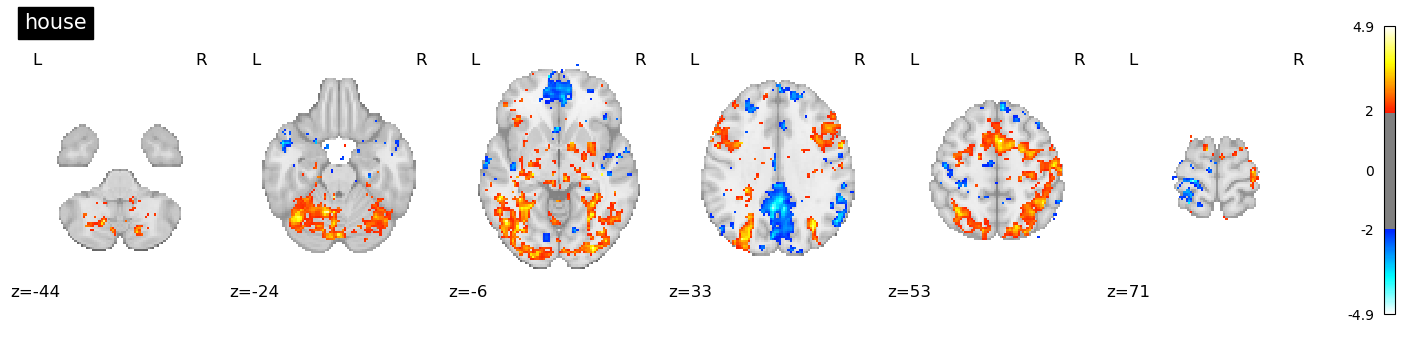

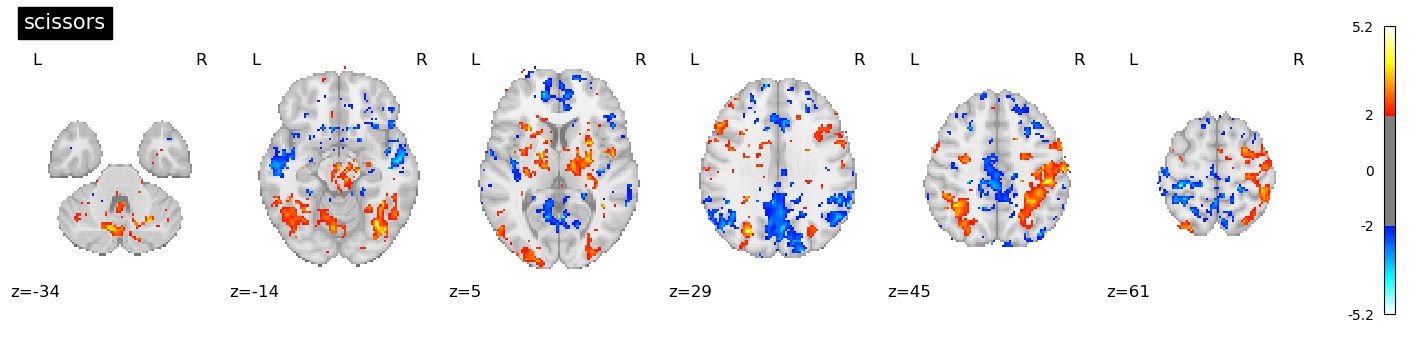

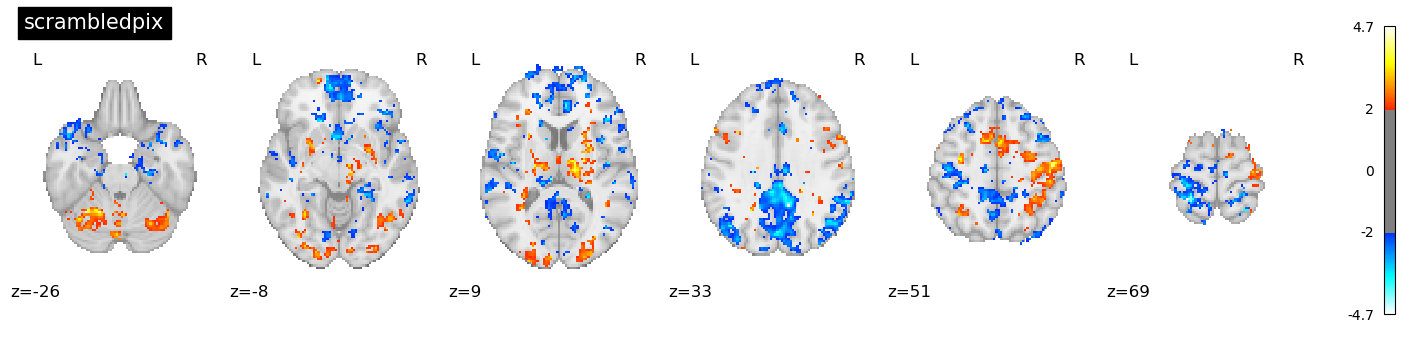

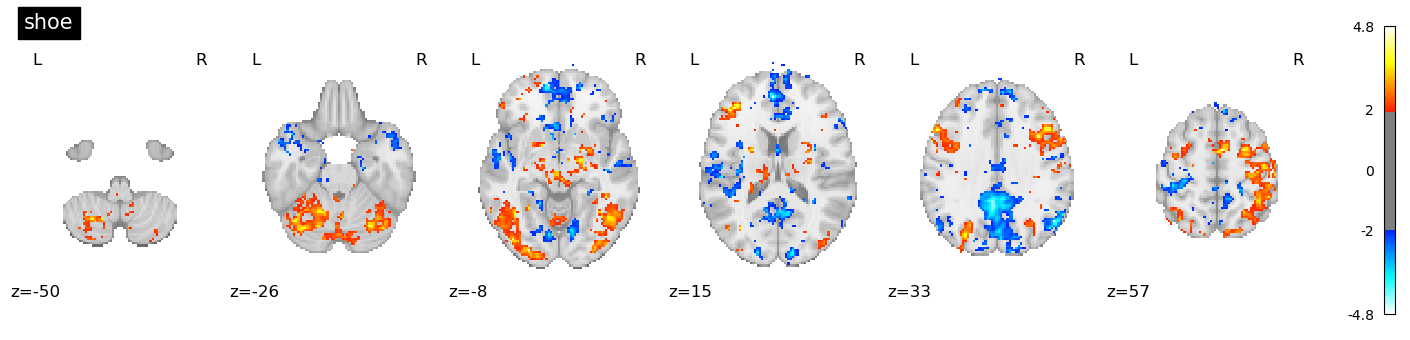

In [12]:
for condition in conditions:
    z_map = load_img(os.path.join(output_dir, 'group_zmaps', f'group_zmap_{condition}.nii.gz'))
    plotting.plot_stat_map(z_map, title=condition, threshold=2.0, display_mode='z', cut_coords=6)
    plt.show()